# 3D U-Net noisy images

### Import files and libraries

In [1]:
import os
from glob import glob
import tifffile
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import monai

In [2]:
# Define directory paths
image_directory = "images/fin/3Dnoisyimages"
ground_truth_directory = "images/fin/3Dlabels"

# Sort files
image_paths = sorted(glob(os.path.join(image_directory, "*")))
label_paths = sorted(glob(os.path.join(ground_truth_directory, "*")))

In [3]:
# Split into train and test sets
image_train, image_test, label_train, label_test = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

In [4]:
class CustomDataset(Dataset):
    """Inherits from torch.Dataset and loads and transforms inputs into tensors"""
    def __init__(self, image_paths, label_paths, image_transforms=None, label_transforms=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Retrieve path of index file
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Read tiff files into numpy array
        image = imread(image_path)
        label = imread(label_path)

        # Add a channel dimension
        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)

        # Convert image/label to tensors with float values
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        if self.image_transforms:
            image = self.image_transforms(image)
        if self.label_transforms:
            label = self.label_transforms(label)

        return image, label

In [5]:
# Resize tensors to target size and normalise by dividing by max value 255.0

target_size = (32, 256, 256)

image_transform = transforms.Compose([
    transforms.Lambda(lambda x: F.interpolate(x.unsqueeze(0), size=target_size, mode="trilinear").squeeze(0)),
    transforms.Lambda(lambda x: x / 255.0)
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda x: F.interpolate(x.unsqueeze(0), size=target_size, mode="nearest").squeeze(0)),
    transforms.Lambda(lambda x: x / 255.0)
])


In [6]:
# Create dataset instance
training_dataset = CustomDataset(image_train, label_train, image_transforms=image_transform, label_transforms=mask_transform)
testing_dataset = CustomDataset(image_test, label_test, image_transforms=image_transform, label_transforms=mask_transform)

image, label = training_dataset[1]
label.shape

torch.Size([1, 32, 256, 256])

In [10]:
# Check values normalised correctly
torch.unique(label)

tensor([0., 1.])

In [11]:
# Create training and test loaders

training_loader = DataLoader(training_dataset, batch_size=1, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=1)

for images, labels in training_loader:
    print(f"Image batch shape: {images.shape}, Label batch shape: {labels.shape}")
    break
for images, labels in testing_loader:
    print(f"Image batch shape: {images.shape}, Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([1, 1, 32, 256, 256]), Label batch shape: torch.Size([1, 1, 32, 256, 256])
Image batch shape: torch.Size([1, 1, 32, 256, 256]), Label batch shape: torch.Size([1, 1, 32, 256, 256])


### Create model

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        # Encoder path convolution and pooling layers
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features*2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features*2, features*4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet._block(features*4, features*8, name="bottleneck")

        # Decoder path upsampling layers
        self.upconv3 = nn.ConvTranspose3d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features*4)*2, features*4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features*2)*2, features*2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features*2, features, name="dec1")

        # Final convolutional layer
        self.conv = nn.Conv3d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    # Computation function (note enc1 is passed input(x), and further encoders passed feature maps of previous pooling layer
    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Decoder path
        dec3 = self.upconv3(bottleneck)
        enc3_cropped = self.center_crop(enc3, dec3.shape[2:])
        dec3 = torch.cat((dec3, enc3_cropped), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        enc2_cropped = self.center_crop(enc2, dec2.shape[2:])
        dec2 = torch.cat((dec2, enc2_cropped), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        enc1_cropped = self.center_crop(enc1, dec1.shape[2:])
        dec1 = torch.cat((dec1, enc1_cropped), dim=1) #enc1_cropped
        dec1 = self.decoder1(dec1)

        if x.shape[2:] != dec1.shape[2:]:
          dec1 = F.interpolate(dec1, size=x.shape[2:], mode='trilinear')

        return torch.sigmoid(self.conv(dec1))

    # Crop if necessary
    def center_crop(self, layer, target_size):
        """Crop to ensure same shape of tensors"""
        _, _, depth, height, width = layer.size()
        target_depth, target_height, target_width = target_size
        delta_d = (depth - target_depth) // 2
        delta_h = (height - target_height) // 2
        delta_w = (width - target_width) // 2

        cropped_layer = layer[:, :,
                            delta_d:delta_d + target_depth,
                            delta_h:delta_h + target_height,
                            delta_w:delta_w + target_width]

        return cropped_layer


    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(num_features=features),
            nn.ReLU(inplace=True),
        )


In [13]:
# Metric and plotting functions

def iou(segmentation, gt):
    """A function to compute IoU"""
    intersection = (segmentation*gt).sum()
    union = segmentation.sum() + gt.sum() - intersection
    score = intersection / union
    return score

def dice(segmentation, gt):
    """A function to compute Dice coefficient"""
    intersection = (segmentation*gt).sum()
    score = (2. *intersection) / (segmentation.sum() + gt.sum())
    return score

### Train model

In [14]:
# Define cuda device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
# Set hyperparameters
num_epochs = 50
model = UNet().to(device)
loss_function = monai.losses.DiceLoss(sigmoid=False)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Store metrics
train_losses = []
test_losses = []
train_ious = []
train_dices = []
test_ious = []
test_dices = []

for epoch in range(num_epochs):

    model.train()
    # Track metrics across each epoch
    running_loss = 0.0 
    running_iou = 0.0
    running_dice = 0.0

    for batch_idx, (images, labels) in enumerate(training_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Ensure the gradients are reset at the start of each iteration
        optimiser.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # Accumulate loss
        running_loss += loss.item()

        # Convert output to binary
        segmentations = (outputs > 0.5).float()

        # Calculate metrics
        batch_iou = iou(segmentations, labels).item()
        batch_dice = dice(segmentations, labels).item()

        running_iou += batch_iou
        running_dice += batch_dice

    # Compute average loss for this epoch
    mean_loss = running_loss / len(training_loader)
    mean_iou = running_iou / len(training_loader)
    mean_dice = running_dice / len(training_loader)

    train_losses.append(mean_loss)
    train_ious.append(mean_iou)
    train_dices.append(mean_dice)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {mean_loss}')

    # Test set
    model.eval()
    test_loss = 0.0
    test_iou = 0.0
    test_dice = 0.0

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in testing_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.item()
            segmentations = (outputs > 0.5).float()
            test_iou += iou(segmentations, labels).item()
            test_dice += dice(segmentations, labels).item()

    # Compute average validation metrics
    mean_test_loss = test_loss / len(testing_loader)
    mean_test_iou = test_iou / len(testing_loader)
    mean_test_dice = test_dice / len(testing_loader)

    # Store validation metrics
    test_losses.append(mean_test_loss)
    test_ious.append(mean_test_iou)
    test_dices.append(mean_test_dice)

    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {mean_test_loss}, IOU: {mean_test_iou}, Dice: {mean_test_dice}')

Epoch 1/50, Training Loss: 0.995471761226654
Epoch 1/50, Test Loss: 0.9732493332454136, IOU: 0.1290453499449151, Dice: 0.21375718393496104
Epoch 2/50, Training Loss: 0.9945968890190124
Epoch 2/50, Test Loss: 0.9957665715898786, IOU: 0.09502687039119857, Dice: 0.17183517664670944
Epoch 3/50, Training Loss: 0.993924593925476
Epoch 3/50, Test Loss: 0.9932739053453717, IOU: 0.04364531034869807, Dice: 0.08346039003559522
Epoch 4/50, Training Loss: 0.9928701877593994
Epoch 4/50, Test Loss: 0.9924406494413104, IOU: 0.04626982845366001, Dice: 0.08823728508182935
Epoch 5/50, Training Loss: 0.9913210153579712
Epoch 5/50, Test Loss: 0.989703186920711, IOU: 0.07057795620390347, Dice: 0.13132124819925853
Epoch 6/50, Training Loss: 0.9890513730049133
Epoch 6/50, Test Loss: 0.9891049180712018, IOU: 0.06372785195708275, Dice: 0.11929255936826978
Epoch 7/50, Training Loss: 0.9851307773590088
Epoch 7/50, Test Loss: 0.9881488851138523, IOU: 0.030055621904986247, Dice: 0.058096785098314285
Epoch 8/50, Tra

In [17]:
# Give directory for metrics to be saved to
results_dir = "output/noisy/3d_unet_noisy_metrics"

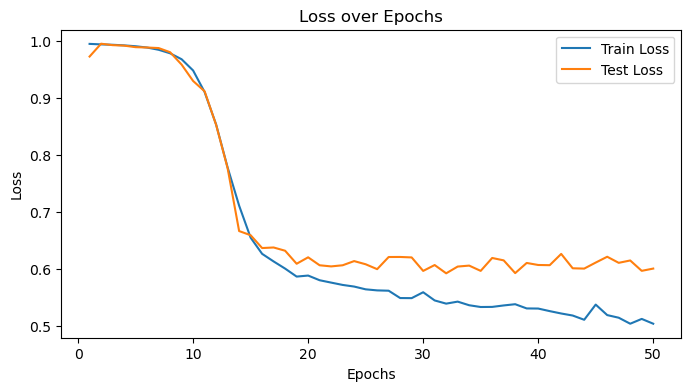

In [18]:
# Plot loss metrics

plt.figure(figsize=(8, 4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.savefig(f"{results_dir}/3d_unet_loss_results.png")
plt.show()

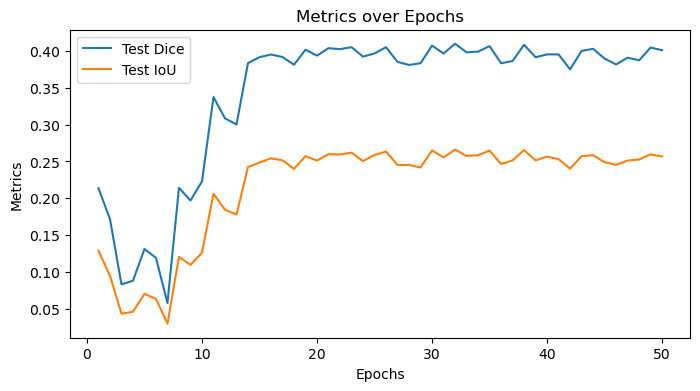

In [19]:
# Plot evaluation metrics

plt.figure(figsize=(8,4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, test_dices, label="Test Dice")
plt.plot(epochs, test_ious, label='Test IoU')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Metrics over Epochs")
plt.legend()

plt.savefig(f"{results_dir}/2d_unet_metrics_results.png")
plt.show()

In [20]:
# Save the model
torch.save(model.state_dict(), "models/noisy_3D_UNet_50_0.pth")

## Inference

In [21]:
# Define model and load weights
my_model = UNet()
my_model.load_state_dict(torch.load("models/noisy_3D_UNet_50_0.pth"))

C:\Users\harry\AppData\Local\Temp\ipykernel_7364\848558830.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load("models/noisy_3D_UNet_50_0

<All keys matched successfully>

In [22]:
total_params = sum(p.numel() for p in my_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 5601121


In [23]:
# Import inference images and masks
img_dir = 'images/fin/inf_set/3Dnoisyimages'
lab_dir = 'images/fin/inf_set/3Dlabels'

image_paths = sorted(glob(os.path.join(img_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(lab_dir, "*.tif")))

In [24]:
inf_images = []
inf_masks = []

target_size = (32, 256, 256)

for image_path, label_path in zip(image_paths, label_paths):
    inf_image = tifffile.imread(image_path)
    inf_mask = tifffile.imread(label_path)

    # Convert 3D image to tensor for trilinear interpolation
    image_tensor = torch.from_numpy(np.expand_dims(inf_image, axis=0)).float()
    resized_image = F.interpolate(image_tensor.unsqueeze(0), size=target_size, mode="trilinear")
    resized_image = resized_image.squeeze().numpy() / 255.0

    # Convert 3D mask to tensor for nearest interpolation
    mask_tensor = torch.from_numpy(np.expand_dims(inf_mask, axis=0)).float()
    resized_mask = F.interpolate(mask_tensor.unsqueeze(0), size=target_size, mode="nearest")
    resized_mask = resized_mask.squeeze().numpy() / 255.0

    inf_images.append(resized_image)
    inf_masks.append(resized_mask)

print(f"Number of images loaded: {len(inf_images)}")
print(f"Shape of the first image: {inf_images[0].shape}")
print(f"Shape of the first mask: {inf_masks[0].shape}")

Number of images loaded: 4
Shape of the first image: (32, 256, 256)
Shape of the first mask: (32, 256, 256)


In [25]:
# set the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

UNet(
  (encoder1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
 

In [26]:
# Output folder to save figures
output_dir_figs = "output/noisy/3d_unet_noisy_inf"

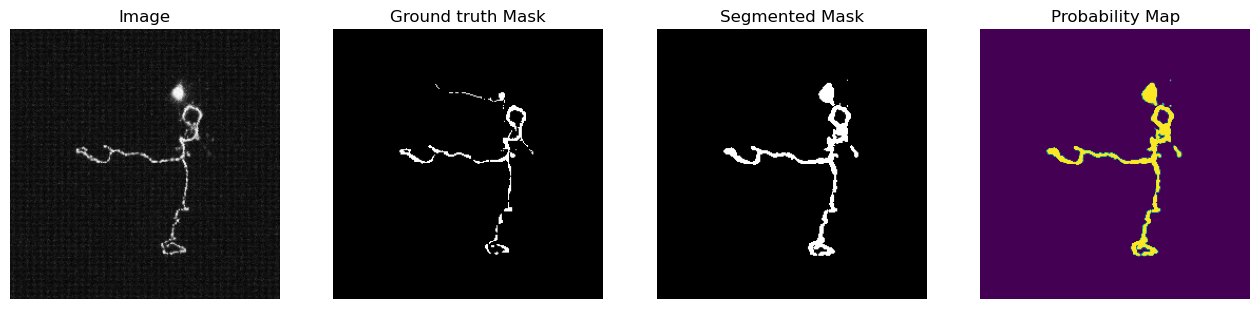

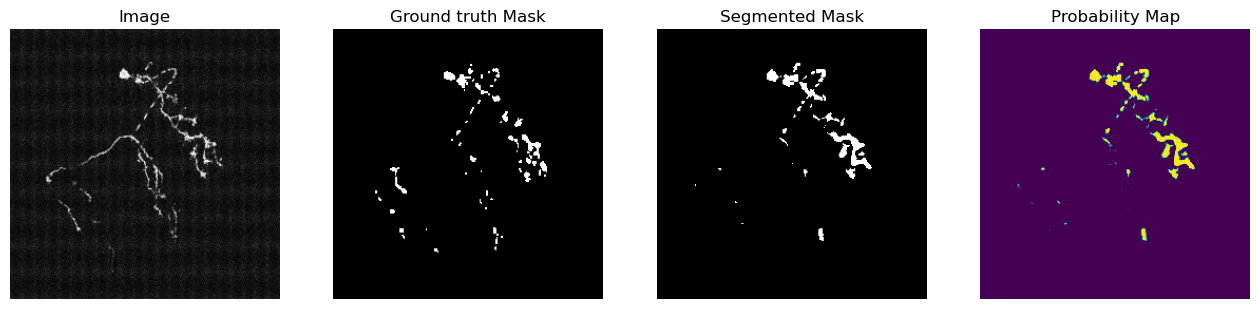

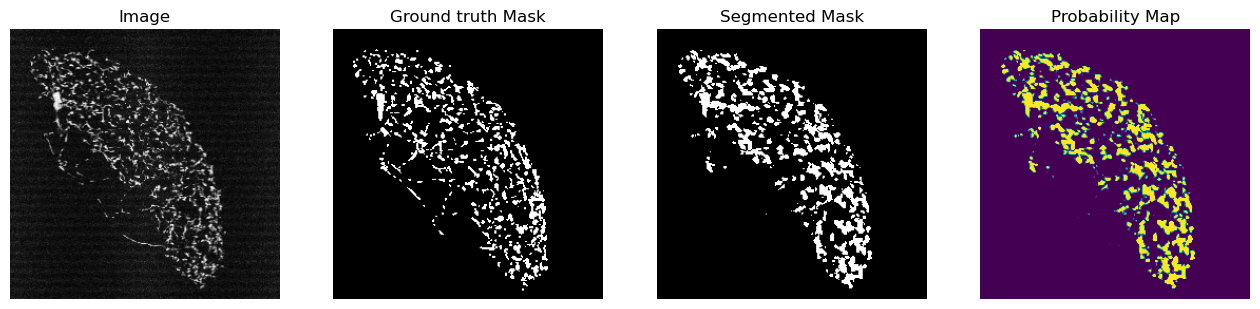

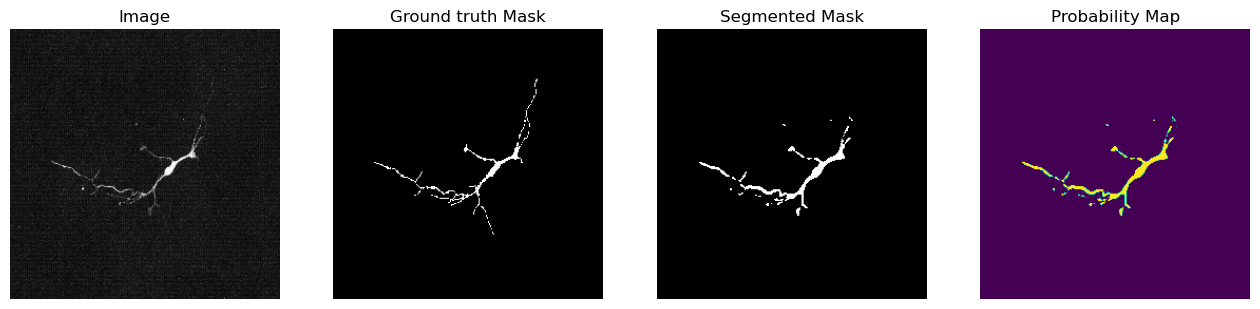

In [27]:
# Ensure the model is in evaluation mode
model.eval()

# Inference loop for each image and ground truth mask
for idx, (test_image, ground_truth_mask) in enumerate(zip(inf_images, inf_masks)):

    # Add dimensions
    test_image_tensor = torch.from_numpy(np.expand_dims(test_image, axis=(0, 1))).float().to(device)
    
    with torch.no_grad():
        # Forward pass
        output = model(test_image_tensor)

        # Probability map
        segmentation_prob = output.cpu().numpy().squeeze()

        # Convert probabilities to binary segmentation using threshold
        bin_segmentation = (segmentation_prob > 0.5).astype(np.uint8)

    mip_image = np.max(test_image, axis=0)
    mip_label = np.max(ground_truth_mask, axis=0)
    mip_segmentation = np.max(bin_segmentation, axis=0)
    mip_probability = np.max(segmentation_prob, axis=0)
    
    # Plot the image, ground truth mask, segmented image, and probability map
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))

    # Plot the original image
    axes[0].imshow(mip_image, cmap='gray')
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Plot the ground truth mask
    axes[1].imshow(mip_label, cmap='gray')
    axes[1].set_title("Ground truth Mask")
    axes[1].axis("off")

    # Plot the binary segmentation mask
    axes[2].imshow(mip_segmentation, cmap='gray')
    axes[2].set_title("Segmented Mask")
    axes[2].axis("off")

    # Plot the probability map
    im = axes[3].imshow(mip_probability, vmin=0, vmax=1)
    axes[3].set_title("Probability Map")
    axes[3].axis("off")

    # Save the figure with a unique index
    plt.savefig(f"{output_dir_figs}/3D_unet_inference_results_{idx}.png", bbox_inches='tight', pad_inches=1)
    plt.show()

In [17]:
new_image = final_images.squeeze()
new_label = final_labels.squeeze()
new_segmentation = final_segmentations.squeeze()
new_image.shape

(32, 256, 256)

In [ ]:
# Output values should be 0 or 1
new_label.unique()

In [ ]:
new_segmentation.unique()

In [18]:
# Z projection
image_z = np.max(new_image, axis=0)
label_z = np.max(new_label, axis=0)
segment_z = np.max(new_segmentation, axis=0)

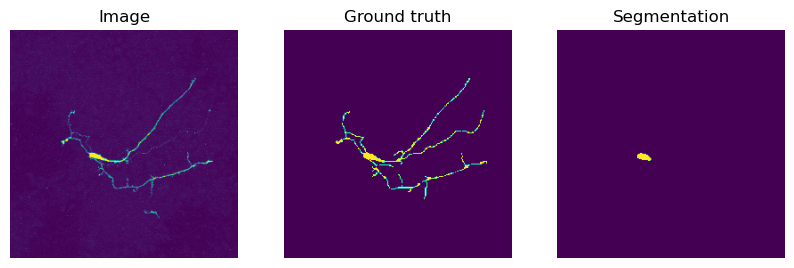

In [19]:
plot_img(image_z, label_z, segment_z)

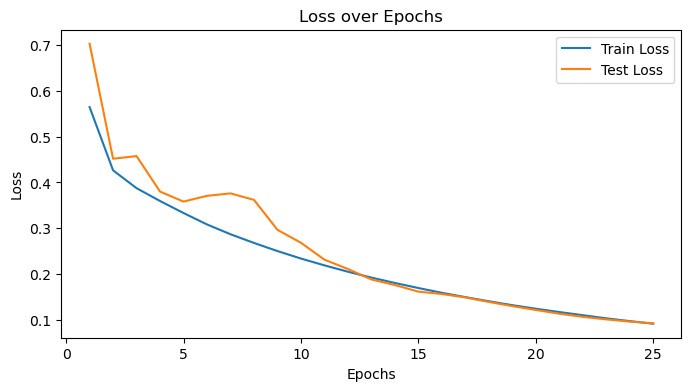

In [20]:
# plot_metrics(training_losses, num_epochs, testing_losses, label="Loss")
plot_metrics(train_losses, num_epochs, label="Loss", test_metric=test_losses)

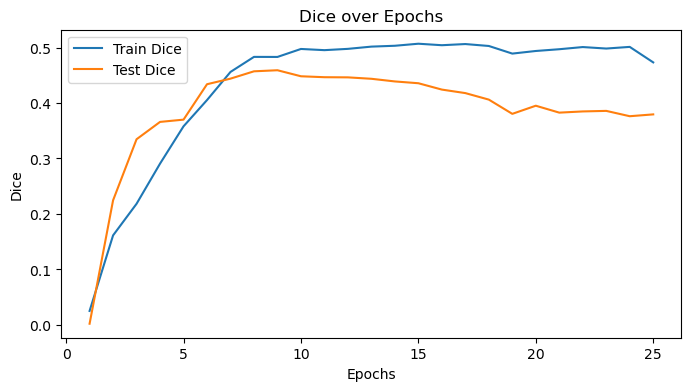

In [21]:
plot_metrics(train_dices, num_epochs=num_epochs, label="Dice", test_metric=test_dices)

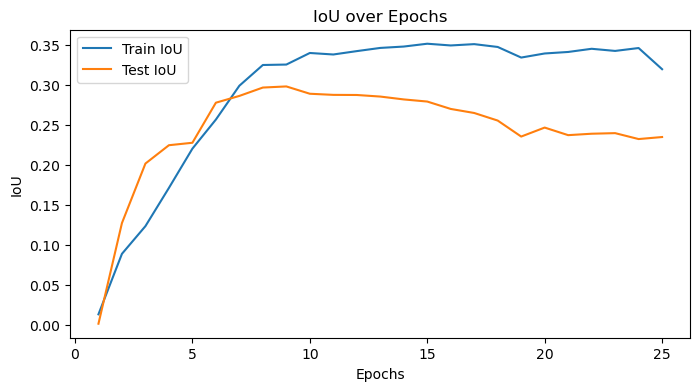

In [22]:
plot_metrics(train_ious, num_epochs, label="IoU", test_metric=test_ious)